# Instagram Influencer Quality Analysis Notebook

This notebook is used to collect and analyze real Instagram data for evaluating influencer quality.  
It pulls information directly from Bright Data’s scraping datasets and allows you to inspect profiles, posts, reels and comments at scale.

The goal of this notebook is to:
- retrieve fresh data for any Instagram creator,
- analyze posting patterns, engagement and audience signals,
- compare influencers across multiple metrics,
- and validate whether their content looks authentic or artificially boosted.

All scraping calls are done through Bright Data’s Dataset API and the helper functions below provide a clean interface for triggering snapshots and downloading results.


In [ ]:
from dotenv import load_dotenv
from typing import Optional, List, Any, Dict
import os
import time
import requests

load_dotenv(override=True)

BASE_URL = "https://api.brightdata.com"
INSTAGRAM_DATASET_ID = "gd_l1vikfch901nx3by4"   
BRIGHTDATA_TOKEN = os.getenv("BRIGHTDATA_API_TOKEN")
INSTAGRAM_POSTS_DATASET_ID = "gd_lk5ns7kz21pck8jpis"
INSTAGRAM_REELS_DATASET_ID = "gd_lyclm20il4r5helnj"  
INSTAGRAM_COMMENTS_DATASET_ID = "gd_ltppn085pokosxh13"

headers = {
    "Authorization": f"Bearer {BRIGHTDATA_TOKEN}",
    "Content-Type": "application/json",
}


## Bright Data Helper Functions for Instagram Scraping

This section defines a small set of reusable helper functions that interact with Bright Data’s Instagram datasets.  
Each function triggers a snapshot, polls until it is ready, and then downloads the final JSON results.

Included functions:
- `fetch_instagram_profile_snapshot()` — collect profile metadata by username  
- `fetch_instagram_posts_by_url()` — collect posts within a date range  
- `fetch_instagram_reels_by_url()` — collect Reels within a date range  
- `fetch_instagram_comments_by_url()` — collect comments for a specific post or reel  

All functions use a shared internal helper `_run_brightdata_snapshot()` to avoid duplication and keep the logic consistent across datasets.


In [ ]:
def _run_brightdata_snapshot(
    trigger_body: Dict[str, Any],
    trigger_params: Dict[str, Any],
    base_url: str,
    poll_interval: int,
    timeout: int,
) -> Any:
    """
    Internal helper to trigger a Bright Data snapshot, poll for completion,
    and download the resulting JSON data.
    """
    # 1. Trigger the snapshot
    trigger_resp = requests.post(
        f"{base_url}/datasets/v3/trigger",
        headers=headers,
        params=trigger_params,
        json=trigger_body,
        timeout=30,
    )
    print("Trigger raw text:", trigger_resp.text)
    trigger_resp.raise_for_status()

    trigger_json = trigger_resp.json()
    snapshot_id = trigger_json.get("snapshot_id")
    if not snapshot_id:
        raise RuntimeError(f"No snapshot_id in trigger response: {trigger_json}")

    print("Trigger response status:", trigger_resp.status_code)
    print("Snapshot ID:", snapshot_id)

    # 2. Poll snapshot progress until it is ready
    progress_url = f"{base_url}/datasets/v3/progress/{snapshot_id}"
    deadline = time.time() + timeout

    while True:
        progress_resp = requests.get(progress_url, headers=headers, timeout=30)
        print("Progress raw:", progress_resp.text[:300])
        progress_resp.raise_for_status()

        progress_json = progress_resp.json()
        status = progress_json.get("status")
        print("Current status:", status)

        if status in {"done", "completed", "ready"}:
            print("Snapshot is ready!")
            break

        if status in {"failed", "error"}:
            raise RuntimeError(
                f"Snapshot failed with status='{status}'. Response: {progress_json}"
            )

        if time.time() > deadline:
            raise TimeoutError(
                f"Snapshot {snapshot_id} timed out after {timeout}s. Last status: {status}"
            )

        time.sleep(poll_interval)

    # 3. Download the snapshot contents as JSON
    download_url = f"{base_url}/datasets/v3/snapshot/{snapshot_id}"
    download_resp = requests.get(
        download_url,
        headers=headers,
        params={"format": "json"},
        timeout=60,
    )
    download_resp.raise_for_status()

    data = download_resp.json()
    print(
        f"Downloaded {len(data) if isinstance(data, list) else 'unknown number of'} records."
    )

    return data


def fetch_instagram_profile_snapshot(
    user_name: str,
    dataset_id: str = INSTAGRAM_DATASET_ID,
    base_url: str = BASE_URL,
    poll_interval: int = 5,
    timeout: int = 300,
):
    """
    Trigger an Instagram snapshot, wait until it is fully processed,
    and download the resulting JSON data.

    Parameters
    ----------
    user_name : str
        Instagram username without '@', e.g. "zoobarcelona".
    dataset_id : str
        Bright Data dataset ID for Instagram.
    base_url : str
        Base Bright Data API URL.
    poll_interval : int
        Time in seconds between progress checks.
    timeout : int
        Maximum time in seconds to wait for snapshot to finish.

    Returns
    -------
        data - parsed JSON from the snapshot.
    """
    trigger_body = {
        "input": [{"user_name": user_name}],
    }

    trigger_params = {
        "dataset_id": dataset_id,
        "notify": "false",
        "include_errors": "true",
        "type": "discover_new",
        "discover_by": "user_name",
    }

    data = _run_brightdata_snapshot(
        trigger_body=trigger_body,
        trigger_params=trigger_params,
        base_url=base_url,
        poll_interval=poll_interval,
        timeout=timeout,
    )

    return data


def fetch_instagram_posts_by_url(
    url: str,
    start_date: str,
    end_date: str,
    num_of_posts: Optional[int] = None,
    post_type: Optional[str] = None,
    posts_to_not_include: Optional[List[str]] = None,
    dataset_id: str = INSTAGRAM_POSTS_DATASET_ID,
    base_url: str = BASE_URL,
    poll_interval: int = 5,
    timeout: int = 300,
) -> Any:
    """
    Trigger an Instagram posts snapshot for a single profile URL, wait
    until it is fully processed, and download the resulting JSON data.

    Parameters
    ----------
    url : str
        Full Instagram profile URL, e.g. "https://www.instagram.com/meta/".
    start_date : str
        Start date filter for posts, as a string, e.g. "01-01-2025".
        (Use the same format as configured in your Bright Data dataset.)
    end_date : str
        End date filter for posts, e.g. "03-01-2025".
    num_of_posts : int, optional
        Maximum number of posts to fetch. If None, the dataset default is used.
    post_type : str, optional
        Post type filter, e.g. "Post", "Reel", or "" for all.
    posts_to_not_include : list of str, optional
        List of post IDs that should be excluded.
    dataset_id : str
        Bright Data dataset ID for Instagram posts.
    base_url : str
        Base Bright Data API URL.
    poll_interval : int
        Time in seconds between progress checks.
    timeout : int
        Maximum time in seconds to wait for snapshot to finish.

    Returns
    -------
    tuple
        data - parsed JSON from the snapshot.
    """
    input_payload: dict = {
        "url": url,
        "start_date": start_date,
        "end_date": end_date,
    }

    if num_of_posts is not None:
        input_payload["num_of_posts"] = num_of_posts

    if post_type is not None:
        input_payload["post_type"] = post_type

    if posts_to_not_include:
        input_payload["posts_to_not_include"] = posts_to_not_include

    trigger_body = {
        "input": [input_payload],
    }

    trigger_params = {
        "dataset_id": dataset_id,
        "notify": "false",
        "include_errors": "true",
        "type": "discover_new",
        "discover_by": "url",
    }

    data = _run_brightdata_snapshot(
        trigger_body=trigger_body,
        trigger_params=trigger_params,
        base_url=base_url,
        poll_interval=poll_interval,
        timeout=timeout,
    )

    return data


def fetch_instagram_reels_by_url(
    url: str,
    start_date: str = "",
    end_date: str = "",
    dataset_id: str = INSTAGRAM_REELS_DATASET_ID,
    base_url: str = BASE_URL,
    poll_interval: int = 5,
    timeout: int = 300,
):
    """
    Trigger an Instagram Reels snapshot for a single profile URL, wait
    until it is fully processed, and download the resulting JSON data.

    Parameters
    ----------
    url : str
        Full Instagram profile URL, e.g. "https://www.instagram.com/espn".
    start_date : str
        Optional start date filter for reels. Format must match the dataset.
        If empty string, no filter is applied.
    end_date : str
        Optional end date filter for reels. If empty string, no filter is applied.
    dataset_id : str
        Bright Data dataset ID for Instagram Reels.
    base_url : str
        Base Bright Data API URL.
    poll_interval : int
        Time in seconds between progress checks.
    timeout : int
        Maximum time in seconds to wait for snapshot to finish.

    Returns
    -------
    data - parsed JSON from the snapshot.
    """
    input_payload = {
        "url": url,
        "start_date": start_date,
        "end_date": end_date,
    }

    trigger_body = {
        "input": [input_payload],
    }

    trigger_params = {
        "dataset_id": dataset_id,
        "notify": "false",
        "include_errors": "true",
        "type": "discover_new",
        "discover_by": "url",
    }

    data = _run_brightdata_snapshot(
        trigger_body=trigger_body,
        trigger_params=trigger_params,
        base_url=base_url,
        poll_interval=poll_interval,
        timeout=timeout,
    )

    return data

def fetch_instagram_comments_by_url(
    url: str,
    dataset_id: str = INSTAGRAM_COMMENTS_DATASET_ID,
    base_url: str = BASE_URL,
    poll_interval: int = 5,
    timeout: int = 300,
) -> Any:
    """
    Trigger an Instagram comments snapshot for a single post URL, wait
    until it is fully processed, and download the resulting JSON data.

    Parameters
    ----------
    url : str
        Full Instagram post or reel URL, e.g.
        "https://www.instagram.com/cats_of_instagram/reel/C4GLo_eLO2e/".
    dataset_id : str
        Bright Data dataset ID for Instagram comments.
    base_url : str
        Base Bright Data API URL.
    poll_interval : int
        Time in seconds between progress checks.
    timeout : int
        Maximum time in seconds to wait for snapshot to finish.

    Returns
    -------
        data - parsed JSON from the snapshot.
    """
    input_payload = {
        "url": url,
    }

    trigger_body = {
        "input": [input_payload],
    }

    trigger_params = {
        "dataset_id": dataset_id,
        "notify": "false",
        "include_errors": "true",
    }

    data = _run_brightdata_snapshot(
        trigger_body=trigger_body,
        trigger_params=trigger_params,
        base_url=base_url,
        poll_interval=poll_interval,
        timeout=timeout,
    )

    return data

## Examples of calls

```
data = fetch_instagram_profile_snapshot("zoobarcelona")

posts_data = fetch_instagram_posts_by_url(
    url="https://www.instagram.com/zoobarcelona/",
    start_date="08-21-2025",  # 3 months back from today, example
    end_date="11-21-2025",
    post_type="Post",
)

reels_data = fetch_instagram_reels_by_url(
    url="https://www.instagram.com/zoobarcelona",
    start_date="10-21-2025",
    end_date="11-21-2025",
)

comments_data = fetch_instagram_comments_by_url(
    url="https://www.instagram.com/cats_of_instagram/reel/C4GLo_eLO2e/"
)

```

### Fetching Instagram Profiles

This cell defines a list of Instagram profile URLs and provides helper functions to extract usernames, request profile snapshots, and store the results.  
Each unique creator is fetched once, and all retrieved profiles are saved into a `profiles.json` file for further analysis.


In [ ]:
import json
from urllib.parse import urlparse

URLS = [
    "https://www.instagram.com/biancafrombrooklyn",
    "https://www.instagram.com/emscakesntreats",
    "https://www.instagram.com/aya_eats_",
    "https://www.instagram.com/bigdoughenergy/",
    "https://www.instagram.com/sorteddelightsby_lini",
    "https://www.instagram.com/breadology101",

    "https://www.instagram.com/theclevercarrot",
    "https://www.instagram.com/BrooklynSourdough",
    "https://www.instagram.com/riseandloaf_sourdoughco",
    "https://www.instagram.com/BlondieandRye",
    "https://www.instagram.com/Maurizio",
    "https://www.instagram.com/october_farms",
    "https://www.instagram.com/the.sourdough.baker",
    "https://www.instagram.com/bookroad.sourdough.co",
    "https://www.instagram.com/giasbatch",
    "https://www.instagram.com/amybakesbread",

    "https://www.instagram.com/artisanbryan",
    "https://www.instagram.com/thebreadahead",
    "https://www.instagram.com/nyc.breadgirl",
    "https://www.instagram.com/oliver_the_baker",
]


def extract_username(url: str) -> str:
    """Extract username from Instagram URL."""
    path = urlparse(url).path
    # /username/, /username → strip slashes
    username = path.strip("/")

    return username


def collect_profiles(urls):
    """Fetch profile snapshots for unique usernames."""
    unique_usernames = {extract_username(u) for u in urls}

    results = []
    for username in unique_usernames:
        try:
            print(f"Fetching: {username}")
            profile = fetch_instagram_profile_snapshot(username)
            if profile:
                results.append(profile)
        except Exception as e:
            print(f"Error fetching {username}: {e}")

    return results


profiles = collect_profiles(URLS)

with open("profiles.json", "w", encoding="utf-8") as f:
    json.dump(profiles, f, ensure_ascii=False, indent=2)

print(f"Saved {len(profiles)} profiles.")


### Minimizing and Ranking Instagram Profiles

This section filters raw profile snapshots, keeps only active creators with sufficient follower counts, and extracts a compact summary of their recent posts.  
The reduced dataset is then passed to a ranking agent, which evaluates how relevant each creator is for the query “NYC home bakers who regularly post sourdough bread.”  
The final output is a JSON-formatted ranked list of accounts.


In [114]:
import os
import json
from datetime import datetime, timedelta, timezone
from typing import Any, Dict, List, Optional

from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.openrouter import OpenRouterProvider


def flatten_profiles(raw_profiles: List[Any]) -> List[Dict[str, Any]]:
    flat: List[Dict[str, Any]] = []
    for item in raw_profiles:
        if isinstance(item, dict):
            flat.append(item)
        elif isinstance(item, list):
            for inner in item:
                if isinstance(inner, dict):
                    flat.append(inner)
    return flat


def parse_instagram_datetime(value: Optional[str]) -> Optional[datetime]:
    if not value:
        return None
    try:
        return datetime.fromisoformat(value.replace("Z", "+00:00"))
    except ValueError:
        return None


def minimize_profiles(
    raw_profiles: List[Any],
    min_followers: int = 1000,
    max_posts_per_profile: int = 10,
    max_inactive_days: int = 180,
) -> List[Dict[str, Any]]:
    flat = flatten_profiles(raw_profiles)
    result: List[Dict[str, Any]] = []

    now = datetime.now(timezone.utc)
    cutoff = now - timedelta(days=max_inactive_days)

    for p in flat:
        if p.get("is_private"):
            continue

        followers = p.get("followers") or 0
        if followers < min_followers:
            continue

        posts = p.get("posts") or []
        if not posts:
            continue

        parsed_dates = [
            parse_instagram_datetime(post.get("datetime")) for post in posts
        ]
        parsed_dates = [d for d in parsed_dates if d is not None]
        if not parsed_dates:
            continue

        last_post_date = max(parsed_dates)
        if last_post_date < cutoff:
            continue

        posts_sorted = sorted(
            posts,
            key=lambda x: x.get("datetime") or "",
            reverse=True,
        )

        post_summaries: List[Dict[str, Any]] = []
        for post in posts_sorted[:max_posts_per_profile]:
            post_summaries.append(
                {
                    "caption": post.get("caption") or "",
                    "datetime": post.get("datetime") or "",
                    "likes": post.get("likes"),
                    "comments": post.get("comments"),
                }
            )

        profile_summary: Dict[str, Any] = {
            "account": p.get("account"),
            "profile_name": p.get("profile_name") or p.get("full_name"),
            "followers": followers,
            "posts_count": p.get("posts_count") or len(posts),
            "biography": p.get("biography"),
            "category_name": p.get("category_name"),
            "avg_engagement": p.get("avg_engagement"),
            "is_business_account": p.get("is_business_account"),
            "is_professional_account": p.get("is_professional_account"),
            "profile_url": p.get("profile_url") or p.get("url"),
            "posts": post_summaries,
        }
        result.append(profile_summary)

    return result


min_profiles = minimize_profiles(profiles)

profiles_json = json.dumps(
    min_profiles,
    ensure_ascii=False,
)

provider = OpenRouterProvider(api_key=os.getenv("OPENROUTER_API_KEY", ""))

model = OpenAIChatModel(
    "anthropic/claude-3.5-sonnet",
    provider=provider,
)

SYSTEM = """
You are an assistant that ranks Instagram profiles for a specific discovery query.

You will receive a JSON array called "profiles". Each item includes:
- high-level profile info (account handle, profile_name, followers, biography, engagement metrics)
- a sample of recent posts (caption, datetime, likes, comments)

Task:
- For the query "NYC home bakers who regularly post sourdough bread", rank these profiles from most to least relevant.
- Take into account:
  - whether the person actually bakes sourdough regularly
  - whether they look like a home baker vs. a large brand or generic cooking account
  - how clearly the bio and posts match NYC + sourdough
- For each profile in the ranked list, return:
  - account handle
  - short relevance_score from 1 (not relevant) to 5 (very relevant)
  - 2-3 sentence explanation of why you ranked it this way.

Output format (JSON only):
[
  {
    "account": "...",
    "relevance_score": 1-5,
    "reason": "..."
  }
]
"""

agent = Agent(
    model=model,
    system_prompt=SYSTEM,
)

PROMPT = f"""
Here is a list of Instagram profiles and a summary of their recent content:

profiles = {profiles_json}

For the query "NYC home bakers who regularly post sourdough bread", rank these profiles from most to least relevant.
Follow the output format described in the system prompt.
"""

result = await agent.run(PROMPT)
ranking = result.output
print(ranking)



Here are the profiles ranked by relevance to "NYC home bakers who regularly post sourdough bread":

[
  {
    "account": "aya_eats_",
    "relevance_score": 4,
    "reason": "Based in NYC as indicated in bio, posts homemade sourdough content regularly based on recent posts. While not exclusively focused on sourdough, they appear to be an active home baker who makes sourdough a key part of their content. Their recent move to NYC and continued sourdough baking makes them particularly relevant."
  },
  {
    "account": "blondieandrye",
    "relevance_score": 3,
    "reason": "While location is not explicitly stated, they regularly post detailed sourdough bread content and have a clear home baking focus. Their posts show consistent sourdough experimentation and technical knowledge, though the NYC connection is unclear."
  },
  {
    "account": "biancafrombrooklyn", 
    "relevance_score": 2,
    "reason": "Based in Brooklyn/NYC and posts homemade food content, but focuses on Italian cookin

### Fetching Posts and Reels for a Test Profile

This cell retrieves both posts and reels for a high-follower Instagram account to inspect its recent activity.  
Using the same Bright Data helpers, it loads six months of content so you can compare posting frequency, engagement patterns, and the differences between feed posts and reels.


In [101]:
test_profile = '_liullland'

posts_data = fetch_instagram_posts_by_url(
    url=f"https://www.instagram.com/{test_profile}/",
    start_date="05-21-2025",  # 6 months back from today 
    end_date="11-21-2025",
    post_type="Post",
)

reels_data = fetch_instagram_reels_by_url(
    url=f"https://www.instagram.com/{test_profile}",
    start_date="05-21-2025",
    end_date="11-21-2025",
)

Trigger raw text: {"snapshot_id":"sd_mibksnig26qh1xsztx"}
Trigger response status: 200
Snapshot ID: sd_mibksnig26qh1xsztx
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","dataset_id":"gd_lk5ns7kz21pck8jpis"}
Current status: running
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","dataset_id":"gd_lk5ns7kz21pck8jpis"}
Current status: running
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","dataset_id":"gd_lk5ns7kz21pck8jpis"}
Current status: running
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","dataset_id":"gd_lk5ns7kz21pck8jpis"}
Current status: running
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","dataset_id":"gd_lk5ns7kz21pck8jpis"}
Current status: running
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","dataset_id":"gd_lk5ns7kz21pck8jpis"}
Current status: running
Progress raw: {"status":"running","snapshot_id":"sd_mibksnig26qh1xsztx","d

### Normalizing and Combining Post Data

This cell standardizes the structure of posts and reels by mapping each record into a unified format.  
After normalization, both datasets are merged into a single DataFrame, timestamps are converted, and the content is chronologically ordered for analysis.


In [ ]:
import pandas as pd

def normalize_item(item: dict, kind: str) -> dict:
    return {
        "kind": kind,   
        "url": item.get("url"),
        "user": item.get("user_posted") or item.get("user_posted_id"),
        "date_posted": pd.to_datetime(item.get("date_posted")),
        "description": item.get("description") or "",
        "hashtags": item.get("hashtags") or [],
        "likes": item.get("likes"),
        "comments": item.get("num_comments"),
 
        "views": item.get("views"),
        "video_play_count": item.get("video_play_count"),
 
        "followers_at_post": item.get("followers"),
        "content_type": item.get("content_type") or item.get("product_type"),
        "top_comments": item.get("top_comments") or item.get('latest_comments'),
        "is_paid_partnership": item.get("is_paid_partnership"),
        "alt_text": item.get("alt_text"),
        "photos_number": item.get("photos_number"),
        
    }

posts_norm = [normalize_item(p, "post") for p in posts_data]
reels_norm = [normalize_item(r, "reel") for r in reels_data]


df = pd.DataFrame(posts_norm + reels_norm)
df["date_posted"] = pd.to_datetime(df["date_posted"], utc=True, errors="coerce")
df = df.sort_values("date_posted").reset_index(drop=True)



In [115]:
df

,kind,url,user,date_posted,description,hashtags,likes,comments,views,video_play_count,...,week,month,hour,hashtags_norm,theme,mentions,date,is_promo,looks_promo,promo_label
0,post,https://www.instagram.com/p/DJ5syvYv4Af,_liullland,2025-05-21 04:05:21+00:00,,[],423,1,NaN,NaN,...,2025-05-19,2025-05-01,4,[],other,[],2025-05-21,False,False,regular
1,post,https://www.instagram.com/p/DJ7JDtAv9M_,_liullland,2025-05-21 17:31:35+00:00,"Just a Wednesday afternoon, BUT in Shanghai😭🤯",[],594,15,NaN,NaN,...,2025-05-19,2025-05-01,17,[],other,[],2025-05-21,False,False,regular
2,reel,https://www.instagram.com/p/DJ8qAFTPkkz/,_liullland,2025-05-22 08:41:19+00:00,We won’t tell him it’s already boiling hot her...,[],650,14,875.0,41956.0,...,2025-05-19,2025-05-01,8,[],other,[],2025-05-22,False,False,regular
3,post,https://www.instagram.com/p/DKCW3MevKS4,_liullland,2025-05-24 12:46:53+00:00,You get all kinds of vibes in this city ✌🏼,[],646,9,NaN,NaN,...,2025-05-19,2025-05-01,12,[],other,[],2025-05-24,False,False,regular
4,reel,https://www.instagram.com/p/DKO3o4aPmc8/,_liullland,2025-05-29 09:29:03+00:00,"No words, just love ♥️",[],172,4,542.0,26862.0,...,2025-05-26,2025-05-01,9,[],other,[],2025-05-29,False,False,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,reel,https://www.instagram.com/p/DRNTBaNjEhN/,_liullland,2025-11-18 18:30:48+00:00,#WhatareLIUwearing Help me! Why this doesn’t w...,"[#WhatareLIUwearing, #tearstrend, #sabrinacarp...",1486,45,32214.0,71806.0,...,2025-11-17,2025-11-01,18,"[#WhatareLIUwearing, #tearstrend, #sabrinacarp...",other,[],2025-11-18,False,False,regular
182,reel,https://www.instagram.com/p/DRPgJTMDIRW/,_liullland,2025-11-19 15:01:46+00:00,#GRWLIU period\n\n#grwm #outfitinspiration #ou...,"[#GRWLIU, #grwm, #outfitinspiration, #outfitof...",1540,92,15528.0,38207.0,...,2025-11-17,2025-11-01,15,"[#GRWLIU, #grwm, #outfitinspiration, #outfitof...",other,[],2025-11-19,False,False,regular
183,reel,https://www.instagram.com/p/DRRe58jjKzE/,_liullland,2025-11-20 09:27:54+00:00,#GRWLIU how we girls actually do it 💥🔥💯,[#GRWLIU],2267,72,27401.0,63998.0,...,2025-11-17,2025-11-01,9,[#GRWLIU],other,[],2025-11-20,False,False,regular
184,post,https://www.instagram.com/p/DRRtG6gjP3A,_liullland,2025-11-20 11:29:39+00:00,Letting my inner child decide about Grandpa or...,[],519,44,NaN,NaN,...,2025-11-17,2025-11-01,11,[],other,[],2025-11-20,False,False,regular


### Preparing Recent Posts for Content Analysis

This section converts the latest posts and reels into a JSON-serializable format, selects a recent subset, and feeds it into an analysis agent.  
Timestamps are formatted consistently, the data is exported as a JSON array, and the agent evaluates themes, engagement trends, posting behavior, and overall content style.


In [ ]:
import json

df_serializable = df[:60].copy()
for col in df_serializable.columns:
    if str(df_serializable[col].dtype).startswith("datetime"):
        df_serializable[col] = df_serializable[col].dt.strftime("%Y-%m-%dT%H:%M:%S")

posts_json = df_serializable.to_dict(orient="records")
posts_json_str = json.dumps(posts_json, ensure_ascii=False)

provider = OpenRouterProvider(api_key=os.getenv("OPENROUTER_API_KEY", ""))

model = OpenAIChatModel(

    "anthropic/claude-3.5-sonnet",
    provider=provider,
)


SYSTEM = """
You are an assistant that analyzes an Instagram creator's recent content.

You will receive a JSON array called "posts". Each item is one post or reel
with fields like:
- kind: post|reel
- date_posted
- url
- description
- hashtags
- likes, comments
- views, video_play_count
- followers_at_post
- content_type
- is_paid_partnership

Your job is to:
1) Identify core themes/topics of the content.
2) Compare posts vs reels performance.
3) Describe posting consistency and frequency.
4) Highlight engagement patterns and what type of content performs best.
5) Mention any commercial/sponsored content if present.
6) Finish with a short summary of how this creator uses Instagram.
Keep it concise and analytical.
"""

PROMPT = f"""
Here is a list of posts and reels from the past 3 months:

posts = {posts_json_str}

Please analyze them according to the system prompt.
"""

agent = Agent(
    model=model,
    system_prompt=SYSTEM,
)


result = await agent.run(PROMPT)
print(result.output)


Here's my analysis of this Instagram creator's content:

1. Core Themes/Topics:
- Fashion and styling (GRWM - "Get Ready With Me" content)
- Personal style mixing casual and elegant pieces
- Travel and lifestyle (visits to Shanghai, London, Wimbledon)
- Family/friendship moments
- Beauty and skincare routines
- Food and dining experiences
- Cultural experiences and events

2. Posts vs Reels Performance:
- Reels generally receive higher engagement with views ranging from 2,000-54,000
- Average likes on reels: 500-1,500
- Average likes on photo posts: 300-700
- Reels focused on outfit transitions and styling perform particularly well
- Photo carousels showing multiple outfit angles/details get steady engagement

3. Posting Consistency:
- Posts 2-3 times per week on average
- Maintains a mix of reels and photo carousels
- Regular content series using #GRWLIU hashtag for outfit/styling content
- Consistent aesthetic and visual style across posts
- Posts during peak engagement hours (typica

### Descriptive Statistics and Thematic Analysis

This cell cleans and enriches the combined posts–reels DataFrame, then computes a series of descriptive statistics for the creator’s content.  
It compares performance of posts vs reels, examines posting frequency by week, month, and hour of day, and extracts hashtags and mentions to surface top topics and brands.  
A simple keyword-based theme classifier groups content into buckets (e.g. baking, seasonal), and the code prints engagement metrics per theme along with a short text summary of overall posting and engagement patterns.


In [116]:
import pandas as pd
from collections import Counter
import re


df = df.copy()
df["date_posted"] = pd.to_datetime(df["date_posted"], utc=True).dt.tz_convert(None)
df["kind"] = df["kind"].fillna("unknown")

for col in ["likes", "comments", "views", "video_play_count", "followers_at_post"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


engagement_by_kind = (
    df.groupby("kind")
    .agg(
        n_posts=("url", "count"),
        avg_likes=("likes", "mean"),
        avg_comments=("comments", "mean"),
        avg_views=("views", "mean"),
        avg_video_play_count=("video_play_count", "mean"),
    )
    .round(2)
)

print("=== Posts vs Reels performance ===")
print(engagement_by_kind)
print()


df["week"] = df["date_posted"].dt.to_period("W").apply(lambda p: p.start_time)
df["month"] = df["date_posted"].dt.to_period("M").astype(str)
df["hour"] = df["date_posted"].dt.hour

posts_per_week = (
    df.groupby("week")["url"]
    .count()
    .rename("posts_per_week")
)

posts_per_month = (
    df.groupby("month")["url"]
    .count()
    .rename("posts_per_month")
)

print("=== Posting frequency (per week) ===")
print(posts_per_week)
print()

print("=== Posting frequency (per month) ===")
print(posts_per_month)
print()

print("=== Posting hours distribution ===")
print(
    df["hour"]
    .value_counts()
    .sort_index()
)
print()


def normalize_hashtags(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        return re.findall(r"#\w+", x)
    return []

df["hashtags_norm"] = df["hashtags"].apply(normalize_hashtags)

all_hashtags = [
    ht.lower()
    for hlist in df["hashtags_norm"]
    for ht in hlist
]

hashtag_counts = Counter(all_hashtags)
top_hashtags = hashtag_counts.most_common(20)

print("=== Top hashtags ===")
for tag, cnt in top_hashtags:
    print(f"{tag}: {cnt}")
print()


THEME_KEYWORDS = {
    "baking": ["bread", "bake", "sourdough", "cake", "donut", "brownie", "cookie"],
    "asian_food": ["dumpling", "ramen", "katsu", "kimchi", "japanese", "korean"],
    "seasonal": ["pumpkin", "halloween", "fall", "autumn", "spice", "holiday"],
}

def detect_theme(desc: str) -> str:
    text = desc.lower()
    matches = []
    for theme, words in THEME_KEYWORDS.items():
        if any(w in text for w in words):
            matches.append(theme)
    if not matches:
        return "other"

    return matches[0]

df["theme"] = df["description"].fillna("").apply(detect_theme)

theme_engagement = (
    df.groupby(["kind", "theme"])
    .agg(
        n_posts=("url", "count"),
        avg_likes=("likes", "mean"),
        avg_comments=("comments", "mean"),
        avg_views=("views", "mean"),
    )
    .round(2)
    .sort_values(["kind", "n_posts"], ascending=[True, False])
)

print("=== Engagement by theme and kind ===")
print(theme_engagement)
print()


def extract_mentions(text: str):
    if not isinstance(text, str):
        return []
    return re.findall(r"@[\w_.]+", text)

df["mentions"] = df["description"].fillna("").apply(extract_mentions)

all_mentions = [
    m.lower()
    for mlist in df["mentions"]
    for m in mlist
]

mention_counts = Counter(all_mentions)
top_mentions = mention_counts.most_common(20)

print("=== Top mentions (brands/accounts) ===")
for m, cnt in top_mentions:
    print(f"{m}: {cnt}")
print()

if "is_paid_partnership" in df.columns:
    paid_share = df["is_paid_partnership"].fillna(False).mean()
    print("=== Paid partnership share ===")
    print(f"{paid_share:.2%} of posts are marked as paid partnership")
    print()


posts_stats = engagement_by_kind.loc["post"] if "post" in engagement_by_kind.index else None
reels_stats = engagement_by_kind.loc["reel"] if "reel" in engagement_by_kind.index else None

print("=== Text summary from stats ===")

if posts_stats is not None and reels_stats is not None:
    print(
        f"Static posts average about {posts_stats['avg_likes']:.0f} likes "
        f"and {posts_stats['avg_comments']:.1f} comments per post, "
        f"while reels reach around {reels_stats['avg_likes']:.0f} likes "
        f"and {reels_stats['avg_comments']:.1f} comments on average."
    )

avg_per_week = posts_per_week.mean()
print(
    f"On average, the creator posts about {avg_per_week:.1f} times per week."
)

top_hours = (
    df["hour"]
    .value_counts(normalize=True)
    .sort_values(ascending=False)
    .head(3)
    .index.tolist()
)
print(
    f"Most content is published in the evening, with activity peaking around: "
    f"{', '.join(str(h) + ':00' for h in top_hours)}."
)

if top_hashtags:
    tags_preview = ", ".join(tag for tag, _ in top_hashtags[:5])
    print(f"Common hashtags include: {tags_preview}.")


=== Posts vs Reels performance ===
      n_posts  avg_likes  avg_comments  avg_views  avg_video_play_count
kind                                                                   
post       68    2128.82         35.51        NaN                   NaN
reel      118    1772.31         35.74   37009.05              94154.33

=== Posting frequency (per week) ===
week
2025-05-19     4
2025-05-26     2
2025-06-02     4
2025-06-09     5
2025-06-16     8
2025-06-23     4
2025-06-30     8
2025-07-07     9
2025-07-14     5
2025-07-21     6
2025-07-28     3
2025-08-04     7
2025-08-11     8
2025-08-18     6
2025-08-25    10
2025-09-01    12
2025-09-08     5
2025-09-15     9
2025-09-22    10
2025-09-29    14
2025-10-06     6
2025-10-13     9
2025-10-20     7
2025-10-27     8
2025-11-03     4
2025-11-10     7
2025-11-17     6
Name: posts_per_week, dtype: int64

=== Posting frequency (per month) ===
month
2025-05     6
2025-06    21
2025-07    30
2025-08    32
2025-09    41
2025-10    35
2025-11    

### Visualizing Engagement and Posting Patterns

This section generates visual summaries of the creator’s content activity.  
It plots how likes evolve over time for posts and reels, shows the distribution of posting times throughout the day, highlights the most frequently used hashtags, and—when available—displays a views-vs-likes scatterplot for reels using log scales to reveal engagement patterns.


/var/folders/66/fl7_dzv10kddsf6t0v_7rb1c0000gn/T/ipykernel_18473/3760231759.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date_posted"].dt.to_period("M").dt.to_timestamp()


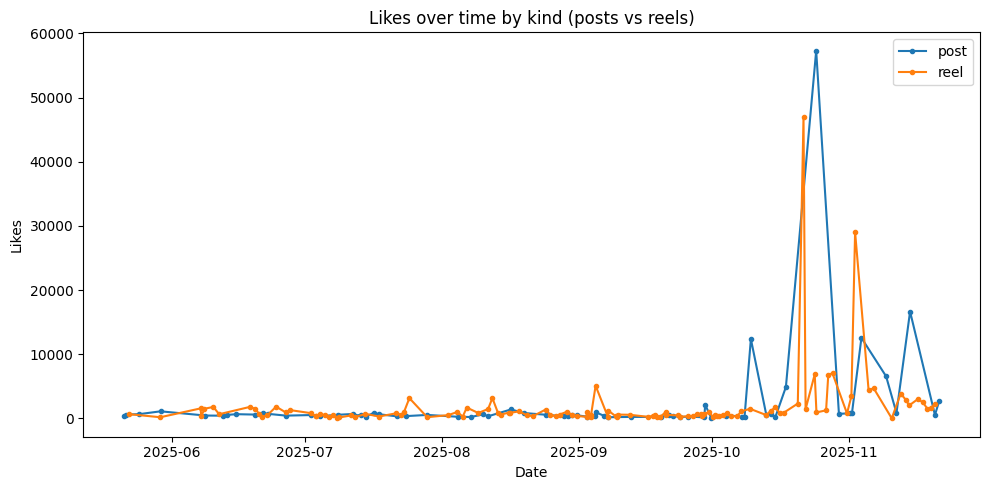

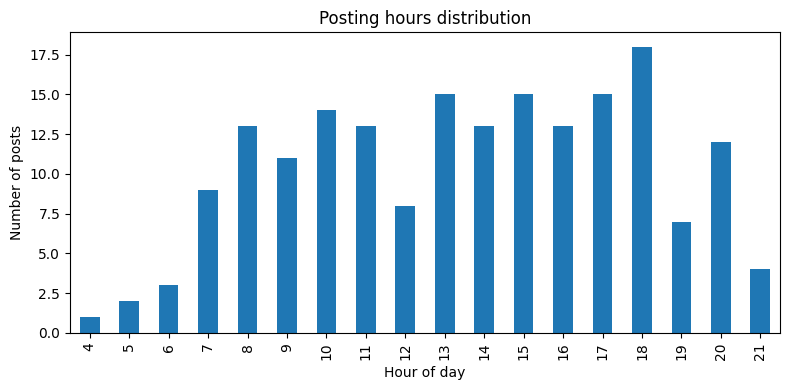

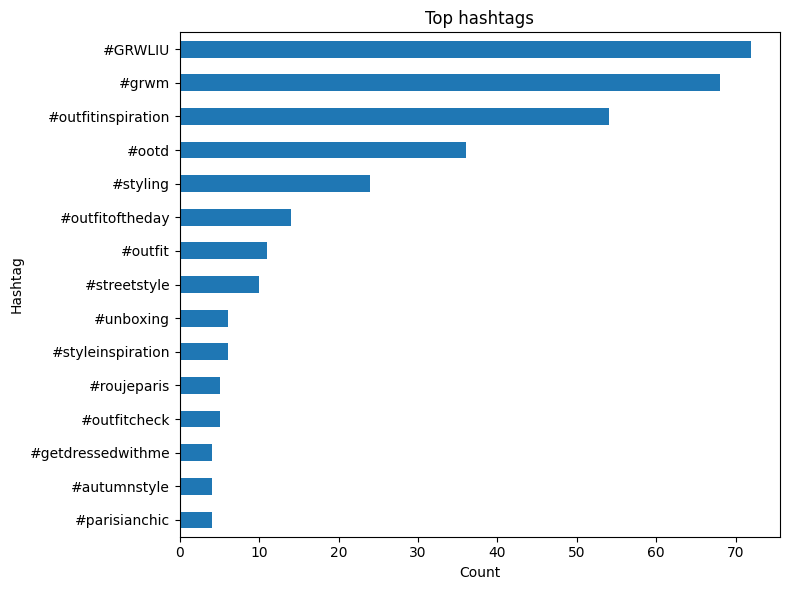

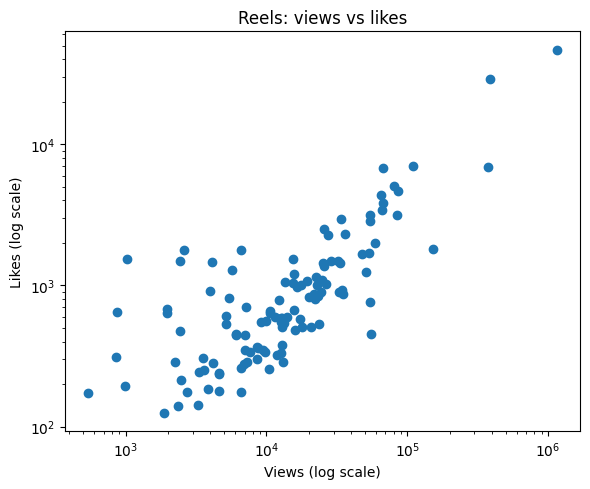

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

df = df.copy()

df["date_posted"] = pd.to_datetime(df["date_posted"], utc=True, errors="coerce")
df = df.dropna(subset=["date_posted"])

df["date"] = df["date_posted"].dt.date
df["month"] = df["date_posted"].dt.to_period("M").dt.to_timestamp()
df["hour"] = df["date_posted"].dt.hour

plt.figure(figsize=(10, 5))
for kind in df["kind"].unique():
    subset = df[df["kind"] == kind]
    subset_sorted = subset.sort_values("date_posted")
    plt.plot(subset_sorted["date_posted"], subset_sorted["likes"], marker=".", linestyle="-", label=kind)

plt.xlabel("Date")
plt.ylabel("Likes")
plt.title("Likes over time by kind (posts vs reels)")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
df["hour"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Number of posts")
plt.title("Posting hours distribution")
plt.tight_layout()
plt.show()

def extract_hashtags(series):
    all_tags = []
    for item in series.dropna():
        if isinstance(item, list):
            all_tags.extend(item)
    return pd.Series(all_tags)

hashtags_series = extract_hashtags(df["hashtags"])
top_tags = hashtags_series.value_counts().head(15)

plt.figure(figsize=(8, 6))
top_tags.sort_values().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.title("Top hashtags")
plt.tight_layout()
plt.show()

if "views" in df.columns:
    reels = df[df["kind"] == "reel"].dropna(subset=["views", "likes"])
    if not reels.empty:
        plt.figure(figsize=(6, 5))
        plt.scatter(reels["views"], reels["likes"])
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Views (log scale)")
        plt.ylabel("Likes (log scale)")
        plt.title("Reels: views vs likes")
        plt.tight_layout()
        plt.show()

 
